# WiFi Fingerprint Extraction from Manually Collected Data

In [1]:
import pandas as pd
import numpy as np

In [2]:
from glob import glob

In [3]:
import os

In [4]:
import sys

PROJECT_HOME = "./../.."
# Add utilities library for Microsoft Indoor Localization 2.0 Dataset
INDOOR_COMPETITION_20_DIR = os.path.join(
    PROJECT_HOME, "code", "indoor-location-competition-20"
)
print("The library is located at", INDOOR_COMPETITION_20_DIR)
sys.path.append(INDOOR_COMPETITION_20_DIR)

The library is located at ./../../code/indoor-location-competition-20


In [5]:
from io_f import read_data_file

In [183]:
from tqdm import tqdm

In [23]:
import matplotlib.pyplot as plt
%matplotlib inline

## Explore the Dataset

In [6]:
sites = list(glob("../../data/train/*"))

In [7]:
len(sites)

204

In [8]:
sites[0]

'../../data/train/5da138b74db8ce0c98bd4774'

In [9]:
list(glob(sites[0] + "/*"))

['../../data/train/5da138b74db8ce0c98bd4774/F5',
 '../../data/train/5da138b74db8ce0c98bd4774/F2',
 '../../data/train/5da138b74db8ce0c98bd4774/B2',
 '../../data/train/5da138b74db8ce0c98bd4774/F4',
 '../../data/train/5da138b74db8ce0c98bd4774/B1',
 '../../data/train/5da138b74db8ce0c98bd4774/F1',
 '../../data/train/5da138b74db8ce0c98bd4774/F3']

In [10]:
len(list(glob(sites[0] + "/F1/*")))

85

In [11]:
track_file_list = list(glob(sites[0] + "/F1/*"))

In [ ]:
path_data = read_data_file(track_file_list[0])

In [189]:
def extract_waypoint_df(waypoint_array: np.ndarray, verbose=False):
  waypoint_schema = {
    "sys_ts": "System timestamp",
    "x": "Coordinate x (meter)",
    "y": "Coordinate y (meter)"
  }

  assert waypoint_array.shape[1] == 3, f"invalid shape, expected: (?, 3), actual: (?, {waypoint_array.shape[1]})"

  waypoint_df = pd.DataFrame(waypoint_array, columns=list(waypoint_schema.keys()))
  waypoint_df["sys_ts"] = waypoint_df["sys_ts"].astype(np.int64)
  waypoint_df["x"] = waypoint_df["x"].astype(np.float32)
  waypoint_df["y"] = waypoint_df["y"].astype(np.float32)
  waypoint_df.sort_values(by="sys_ts", inplace=True)

  if verbose:
    sys_time_diff = (waypoint_df["sys_ts"].values[1:] - waypoint_df["sys_ts"].values[:-1]) / 1000
    print(f"Summary stats: n_samples={waypoint_df.shape[0]}, mean={sys_time_diff.mean():.2f}s, std={sys_time_diff.std():.2f}s")

  return waypoint_df


In [190]:
waypoint_df = extract_waypoint_df(path_data.waypoint)

In [191]:
def extract_wifi_df(wifi: np.ndarray, verbose=False):
  wifi_schema = {
    "sys_ts": "system timestamp",
    "ssid": "the network name",
    "bssid": "the MAC address of the AP",
    "rssi": "RSSI",
    "freq": "Frequency",
    "last_seen_ts": "timestamp in microseconds (since boot) when this result was last seen"
  }
  wifi_df = pd.DataFrame(wifi, columns=list(wifi_schema.keys()))
  wifi_df["bssid"] = wifi_df["bssid"].astype("category")
  wifi_df["ssid"] = wifi_df["ssid"].astype("category")
  wifi_df["sys_ts"] = wifi_df["sys_ts"].astype(np.int64)
  wifi_df["last_seen_ts"] = wifi_df["last_seen_ts"].astype(np.int64)
  wifi_df["rssi"] = wifi_df["rssi"].astype(np.int32)
  wifi_df["freq"] = wifi_df["freq"].astype(np.int32)

  if verbose:
    print(f"Summary stats: n_samples={wifi_df.shape[0]}, n_seen_bssid={wifi_df.bssid.unique().shape[0]}, n_seen_ssid={wifi_df.ssid.unique().shape[0]}")
  return wifi_df

In [188]:
wifi_df = extract_wifi_df(path_data.wifi)

## Interpolate waypoints for WiFi fingerprints


In [195]:
def interpolate_wifi_waypoints(waypoint_df: pd.DataFrame, track_wifi_df: pd.DataFrame, max_offset_sec: int=2) -> pd.DataFrame:
  """
  Interpolation Rules:
  - For points with timestamps near the start and end waypoints, assign the locations of start/end waypoints to these points.
  - For points with timestamps between those of start and end waypoints, linear interpolate locations of these points.

  Params:
    waypoint_df: a pd.DataFrame represents waypoints
    track_wifi_df: a pd.DataFrame represents wifi fingerprints
    max_offset_sec: maximum offset in seconds

  Returns: a pd.DataFrame of wifi waypoints
  """
  assert "sys_ts" in waypoint_df.columns
  assert "sys_ts" in track_wifi_df.columns

  max_offset_millis = max_offset_sec * 1000

  waypoint_ts = waypoint_df["sys_ts"].values
  waypoint_x, waypoint_y = waypoint_df["x"].values, waypoint_df["y"].values

  wifi_ts = track_wifi_df["sys_ts"].unique()

  interpolated_x = np.ones_like(wifi_ts, dtype=np.float32) * -1
  interpolated_y = np.ones_like(wifi_ts, dtype=np.float32) * -1

  # Points near the left pivot
  left_pivot_mask = (wifi_ts <= waypoint_ts[0]) & (waypoint_ts[0] - wifi_ts <= max_offset_sec)
  interpolated_x[left_pivot_mask] = waypoint_x[0]
  interpolated_y[left_pivot_mask] = waypoint_y[0]

  # Points near the right pivot
  right_pivot_mask = (wifi_ts > waypoint_ts[-1]) & (wifi_ts - waypoint_ts[-1] <= max_offset_sec)
  interpolated_x[right_pivot_mask] = waypoint_x[-1]
  interpolated_y[right_pivot_mask] = waypoint_y[-1]
  
  # Inner points: waypoint_ts[left_idx] < wifi_ts <= waypoint_ts[right_idx]
  right_idx = np.searchsorted(waypoint_ts, wifi_ts, side="left")
  left_idx = right_idx - 1
  inner_mask = (right_idx > 0) & (right_idx < len(waypoint_ts))
  prev_waypoint_ts, next_waypoint_ts = waypoint_ts[left_idx[inner_mask]], waypoint_ts[right_idx[inner_mask]]
  frac = (wifi_ts[inner_mask] - prev_waypoint_ts) / (next_waypoint_ts - prev_waypoint_ts)
  interpolated_x[inner_mask] = waypoint_x[left_idx[inner_mask]] + frac * (waypoint_x[right_idx[inner_mask]] - waypoint_x[left_idx[inner_mask]])
  interpolated_y[inner_mask] = waypoint_y[left_idx[inner_mask]] + frac * (waypoint_y[right_idx[inner_mask]] - waypoint_y[left_idx[inner_mask]])

  keep_mask = interpolated_x != -1
  wifi_waypoint_df = pd.DataFrame(
    np.vstack([wifi_ts[keep_mask], interpolated_x[keep_mask], interpolated_y[keep_mask]]).T, 
    columns=["sys_ts", "x", "y"])

  return wifi_waypoint_df

In [159]:
wifi_waypoint_df = interpolate_wifi_waypoints(waypoint_df, wifi_df, max_offset_sec=2)

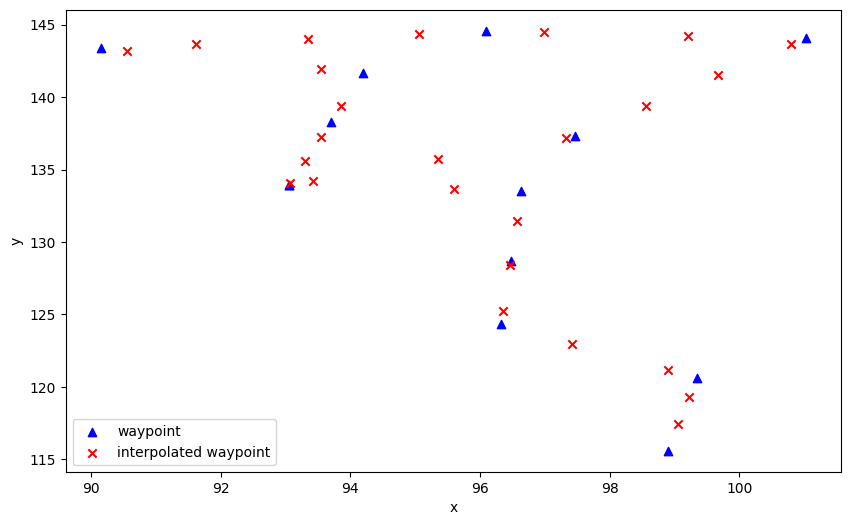

In [160]:
fig, ax = plt.subplots(1, 1, figsize=(10, 6))
ax.scatter(waypoint_df["x"].values, waypoint_df["y"].values, marker="^", color="blue", label="waypoint")
ax.scatter(wifi_waypoint_df["x"].values, wifi_waypoint_df["y"].values, marker="x", color="red", label="interpolated waypoint")

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

plt.show()

In [161]:
wifi_fingerprint_df = pd.merge(wifi_df, wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")

## Ground-truth Data Extraction Pipeline

In [166]:
input_dir = "../../data/train/"
output_dir = "../../data/wifi_fingerprint_manual/train/"

if not input_dir.endswith("/"):
  input_dir += "/"

if not output_dir.endswith("/"):
  output_dir += "/"

In [165]:
input_sites = list(glob(input_dir + "*"))

In [185]:
track_list = []

for site_path in input_sites:
  site_id = os.path.basename(site_path)
  
  input_floor_paths = glob(site_path + "/*")
  for input_floor_path in input_floor_paths:
    floor_id = os.path.basename(input_floor_path)

    # Track
    track_path_list = list(glob(input_floor_path + "/*"))
    track_list.extend([
      {
        "site_id": site_id,
        "floor_id": floor_id,
        "track_id": os.path.splitext(os.path.basename(track_path))[0],
        "track_path": track_path,
      }
      for track_path in track_path_list
    ])
    
track_list_df = pd.DataFrame(track_list)

In [199]:
%%time

failed_tracks = []

for track_spec in tqdm(track_list):
  output_path = output_dir + track_spec["site_id"] + "/" + track_spec["floor_id"]
  if not os.path.exists(output_path):
    os.makedirs(output_path)
  
  try:
    # Read input
    path_data = read_data_file(track_spec["track_path"])

    # Extract and transform the datasets
    waypoint_df = extract_waypoint_df(path_data.waypoint)
    wifi_df = extract_wifi_df(path_data.wifi)
    wifi_waypoint_df = interpolate_wifi_waypoints(waypoint_df, wifi_df, max_offset_sec=2)
    wifi_fingerprint_df = pd.merge(wifi_df, wifi_waypoint_df, left_on="sys_ts", right_on="sys_ts")

    # Save output
    waypoint_df.to_csv(output_path + "/" + track_spec["track_id"] + "_waypoint.csv", index=False, header=True)
    wifi_df.to_csv(output_path + "/" + track_spec["track_id"] + "_wifi.csv", index=False, header=True)
    wifi_fingerprint_df.to_csv(output_path + "/" + track_spec["track_id"] + "_wifi_fingerprint.csv", index=False, header=True)
  
  except Exception as e:
    failed_tracks.append(track_spec)
    print(f"[ERROR] Failed to process track located at {track_spec['track_path']}, caused by: {str(e)}")

  2%|▏         | 672/26925 [01:52<1:12:57,  6.00it/s]


KeyboardInterrupt: 

: 